#### Plotting Lineage Prevalence

In this example, we will show how to plot the prevalence of a specific lineage from both wastewater and clinical data. Before starting make sure the Python-outbreak-data package is up-to-date and import all necessary plotting and data analysis packages. Here are the ones we used for this plot:

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)


/tmp/ipykernel_945010/3826763493.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Authenticate your credentials in GISAID if you haven't done so yet.

In [2]:
from outbreak_data import authenticate_user
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/YDMAZNNNLZVWWYBFWGSFVCERHZHHAXHLYCTVRGJFIWKWULXWGHGYLYQEXVSTSDJHQJBELEXWQQRFWAUACRGJUKWZSQYBKSTLPNXAPJJUSTYHGKLWIVLIPYGIKAISCSBX
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Database Access
    Agreement;
    2. You will not distribute, or re-distribute Data made available through
    GIS

In [3]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools
from outbreak_tools import outbreak_clustering

In [4]:
# Saves and plots figure
def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

# Smooths data for plotting - required
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35) 

#### Pull wastewater and clinical data

First specify the location and date range for analysis and collect the daily lineage and mutation data from the wastewater samples. Then do the same for the clinical data.

In [5]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info')
ww_lineages = outbreak_data.get_wastewater_lineages(ww_samples, server='dev.outbreak.info')

In [6]:
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)
ww_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=1, log=False)
ww_prevalences_daily, ww_prevalences_daily_varis = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, log=False, variance=True)

In [16]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1, ndays=365)
clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=1, freq='D', log=False)
clinical_prevalences_daily, clinical_prevalences_daily_varis = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=smooth, freq='D', log=False, variance=True)

#### Get the lineage tree data

To group the wastewater data properly for graphing, we need to get lineage data from the pre-parsed lineage tree (derived from the Pangolin project). This will help us organize and cluster lineages later.

In [8]:
tree = outbreak_clustering.get_compressed_tree()
lineage_key = outbreak_clustering.get_lineage_key(tree)

#### Cluster lineages 

Now we generate clustered groups given our prevalence and lineage tree data. We can use one set of clusters for both wastewater and clinica data.

In [17]:
ww_prev_data = ww_prevalences.sum()
clusters = outbreak_clustering.cluster_lineages(ww_prev_data, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### Preparing clustered daily prevalence data for plotting

Next we want to apply the clusters to our clinical and wastewater data. From this we will get daily prevalences and variance data to use for our visual. 

In [18]:
clustered_ww_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)

clustered_cl_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)

#### Lineage Prevalence Graph

Use this function to ensure the data is normalized for the graph.

In [19]:
# Normalizing data 
def lognorm_ci(x, r):
    return (np.exp(np.log(x)-(r**0.5/x)), np.exp(np.log(x)+(r**0.5/x)))

With our clustered wastewater and prevalence data, we can now apply this to any lineage of our choice. We'll pick one from the clinical data set and graph the prevalence data.

In [20]:
lin = clustered_ww_prevalences_daily.columns[-1]

This is what the raw unsmoothed data looks like as a scatter plot:

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


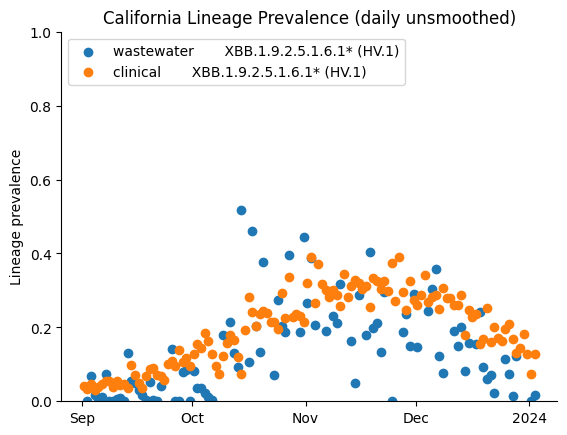

In [21]:
_,ax = plt.subplots()
l,u = lognorm_ci(clustered_ww_prevalences_daily_unsmoothed[lin], clustered_ww_prevalences_daily_varis[lin])
ax.scatter(clustered_ww_prevalences_daily_unsmoothed.index.mid, clustered_ww_prevalences_daily_unsmoothed[lin], label=f'wastewater {lin}')
# ax.fill_between(clustered_ww_prevalences_daily_unsmoothed.index.mid, l, u, alpha=0.3, zorder=-1)

l,u = lognorm_ci(clustered_cl_prevalences_daily_unsmoothed[lin], clustered_cl_prevalences_daily_varis[lin])
ax.scatter(clustered_cl_prevalences_daily_unsmoothed.index.mid, clustered_cl_prevalences_daily_unsmoothed[lin], label=f'clinical {lin}')
# ax.fill_between(clustered_cl_prevalences_daily_unsmoothed.index.mid, l, u, alpha=0.3, zorder=-1)

ax.set_ylim(0, 1)
ax.set_ylabel('Lineage prevalence')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
plt.title(f'{state} Lineage Prevalence (daily unsmoothed)')
plot_out('lin_prev_plot_rolling.pdf')

Here is the smoothed plot of the daily rolling prevalence data:

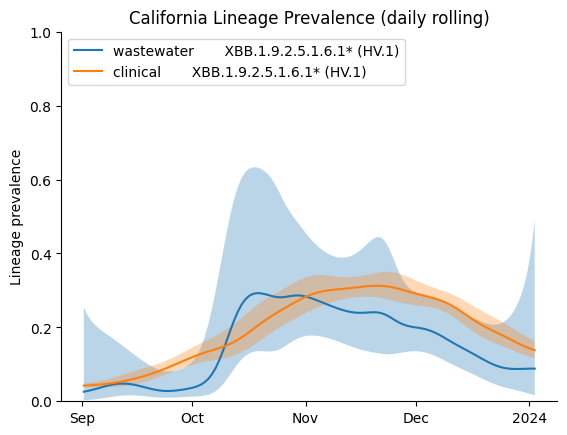

In [22]:
_,ax = plt.subplots()
l,u = lognorm_ci(clustered_ww_prevalences_daily[lin], clustered_ww_prevalences_daily_varis[lin])
ax.plot(clustered_ww_prevalences_daily.index.mid, clustered_ww_prevalences_daily[lin], label=f'wastewater {lin}')
ax.fill_between(clustered_ww_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

l,u = lognorm_ci(clustered_cl_prevalences_daily[lin], clustered_cl_prevalences_daily_varis[lin])
ax.plot(clustered_cl_prevalences_daily.index.mid, clustered_cl_prevalences_daily[lin], label=f'clinical {lin}')
ax.fill_between(clustered_cl_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

ax.set_ylim(0, 1)
ax.set_ylabel('Lineage prevalence')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
plt.title(f'{state} Lineage Prevalence (daily rolling)')
plot_out('lin_prev_plot_rolling.pdf')

A brief example of getting lineage prevalence exclusive of some sublineages:

In [64]:
cl_q = outbreak_data.lineage_cl_prevalence('XBB', descendants=True, exclude_descendants=['HV.1'], lineage_key=lineage_key, datemin=startdate, datemax=enddate)['proportion']
cl_q.index = pd.to_datetime(cl_q.index)

In [65]:
ww_q = ww_prevalences_daily.apply(lambda p: outbreak_clustering.get_agg_prevalence(lineage_key['XBB'], p, [lineage_key['HV.1']]), axis=1)
ww_q.index = ww_q.index.mid

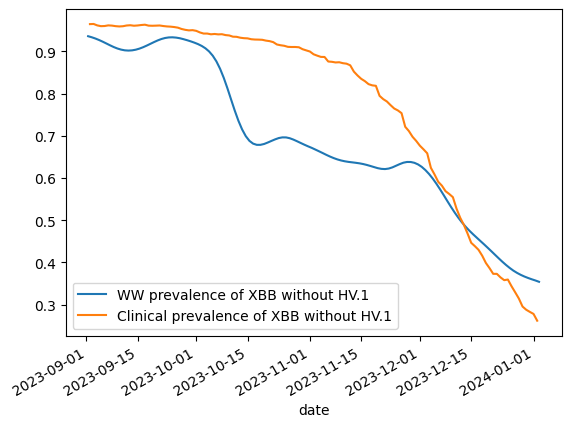

In [67]:
ww_q.plot(label='WW prevalence of XBB without HV.1')
cl_q.plot(label='Clinical prevalence of XBB without HV.1')
plt.legend()
plt.xticks(rotation=30)
plt.show()